<a href="https://colab.research.google.com/github/Lahiru-mta/Sentinel-1/blob/main/Sentinel_1_point_inspector_(Temporal_Patterns).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Get authorize access by Earth Engine
import ee
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=pnfhJGYjKsDjgCAVBng0w69XmebIlxPnqlJAvIByzWI&tc=SIfvm7lEQbFp8LvgkD5r99NPlvsNdjm0uowrTv6cOsM&cc=tWbNsRYcYUn_41EoMv9UmemCnc3zuKBiI6JtCJcSD5g

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1ARtbsJqZxR8i26QdPNm0F7TLt7QrfrcF00lZ36X64zRX2nPnbGQYR5Lxmvo

Successfully saved authorization token.


In [2]:
#@title Connect to Google Drive
#@markdown (To save outputs)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#@title Import dependencies
!pip install geemap --quiet
!pip install pydub --quiet

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
from IPython.display import clear_output 
import ipywidgets as widgets
%matplotlib inline
from datetime import datetime
import gdown
import geemap
import time

import shutil
import os
from pydub import AudioSegment
from pydub.utils import make_chunks

clear_output() 

In [4]:
#@title Define functions

def ndi(img_1,img_2):
  img_1 = img_1.select(band)
  img_3 = img_2.select(band).multiply(-1)
  img_2 = img_2.select(band)
  subtraction = img_1.add(img_3)
  addition = img_1.add(img_2)
  nd_1 = subtraction.divide(addition)
  return nd_1

In [5]:
#@title graph parameters

font_size = 20 #@param 
#@markdown size of the plot
width = 20 #@param
height = 6 #@param

plt.rcParams.update({'font.size': font_size})


In [6]:
#@title Parameters
#@markdown Parameters for the sentinel 1 image collection
Start_Date = '2021-08-01' #@param {type:"date"}
start_date = Start_Date
End_Date = '2022-01-03'  #@param {type:"date"}
end_date = End_Date
bands_list = ['VV','VH']
Band = 'VH' #@param ['VV','VH']
band = Band
# images per seen
# no_imgs =   1#@param {type : 'integer'}
#pixel size for points in m
Scale = 10  #@param {type : 'slider', min:0, max:90, step:10  }
scale = Scale
#@title Clip to AOI (Please run this script as well)

Use_AOI_to_Clip = False #@param {type:"boolean"}
#@markdown (Otherwise clipping is done according to the points)

if Use_AOI_to_Clip == True :

    Upper_left = [80.3810421073104, 8.174762803434588] #@param {}
    Bottom_Right = [80.71749840613853,  8.476420079188712] #@param {}

    lon_1 = Upper_left[0]
    lon_2 = Bottom_Right[0]
    lat_1 = Upper_left[1]
    lat_2 = Bottom_Right[1]

    AOI_coordinates =  [[lon_1, lat_2],
                        [lon_1, lat_1],
                        [lon_2, lat_1],
                        [lon_2, lat_2],
                        [lon_1, lat_2]]

    Show_on_Map = False #@param {type:"boolean"}
    # coords = geoJason['features'][0]['geometry']['coordinates']
    # aoi = ee.Geometry.Polygon(coords)
    aoi = ee.Geometry.Polygon(AOI_coordinates)

    if Show_on_Map == True:
      center = [(lat_1+lat_2)/2,(lon_1+lon_2)/2]
      Map = geemap.Map(center = (center[0], center[1]), zoom=10)
      Map.addLayer(aoi,{},'aoi')
      display(Map)



In [7]:
#@title Points
How_to_import_points = 'Import CSV' #@param ['Insert Coordinates','Import CSV']
#@markdown Insert the point list below ex:  [ [79.93106, 6.86854] , [79.93299, 6.86764] ] .
if How_to_import_points == 'Insert Coordinates':
  points_list = [ [79.93106135950266, 6.868540981780344] , [79.93299254999339, 6.867646226642036] , [79.93248782875358, 6.868387024081292] , [79.93272386314689, 6.868108744671682]] #@param {}
  field_data_df = pd.DataFrame(points_list, columns = ['Lon', 'Lat'])
#@markdown OR paste the Google Drive Shared link of the CSV below ex: " https://drive.google.com/file/d/1QKimP8DQl7cgHJ8SpYitwTOwvPGdu-lt/view?usp=sharing "
if How_to_import_points == 'Import CSV':
  CSV_link = 'https://drive.google.com/file/d/19qZW3tA94Aa9NaKscvkc6s9h25-qRq3W/view?usp=sharing'#@param{type : "string"}
  # 'https://drive.google.com/uc?id=1P3EFH5v8pOkJOUbDEmB_EpmqIbrHUZHk'
  url = 'https://drive.google.com/uc?id=' + CSV_link[32:65]
  File_name = 'field_data' #param{type : "string"}
  out = File_name +'.csv'

  gdown.download(url, out, quiet=True)
  # print('successfully downloaded')

  field_data_df = pd.read_csv('/content/'+ out)

  headers = field_data_df.columns.tolist()

  Lon = widgets.Dropdown(    options=headers,    value=headers[0],    description='Longitude:')
  display(Lon)
  Lat = widgets.Dropdown(    options=headers,    value=headers[1],    description='Latitude:')
  display(Lat)

  if len(headers) >2:
    Detail = widgets.Dropdown(    options=headers,    value=headers[2],    description='Detail:')
    display(Detail)



Dropdown(description='Longitude:', options=('Lon', 'Lat'), value='Lon')

Dropdown(description='Latitude:', index=1, options=('Lon', 'Lat'), value='Lat')

In [8]:
#@title Arrange Points
if How_to_import_points == 'Insert Coordinates':
  lon = 'Lon'
  lat = 'Lat'


if How_to_import_points == 'Import CSV':
  lon = headers[Lon.index]
  lat = headers[Lat.index]


points_list_df = field_data_df.filter([lon,lat])
points_list = points_list_df.values.tolist()
point_features = []
for i in range (len(points_list)):
  point_features.append(ee.Feature(ee.Geometry.Point(points_list[i]), {'id': i}))

points_fc = ee.FeatureCollection(point_features)
points = ee.Geometry.MultiPoint(points_list)

if Use_AOI_to_Clip == False :
  lat_1 = min(np.array(points_list)[:,1:])[0] - 0.01
  lat_2 = max(np.array(points_list)[:,1:])[0] + 0.01
  lon_1 = min(np.array(points_list)[:,:1])[0] - 0.01
  lon_2 = max(np.array(points_list)[:,:1])[0] + 0.01

  AOI_coordinates =  [[lon_1, lat_2],
                        [lon_1, lat_1],
                        [lon_2, lat_1],
                        [lon_2, lat_2],
                        [lon_1, lat_2]]

  # coords = geoJason['features'][0]['geometry']['coordinates']
  # aoi = ee.Geometry.Polygon(coords)
  aoi = ee.Geometry.Polygon(AOI_coordinates)
  # print(aoi.getInfo())

Show_Point_List = True  #@param {type:"boolean"}
if Show_Point_List == True:
    display(field_data_df)

Show_points_on_map = False  #@param {type:"boolean"}
if Show_points_on_map == True :
    center = [(lat_1+lat_2)/2,(lon_1+lon_2)/2]
    Map = geemap.Map(center = (center[0], center[1]), zoom=15)
    Map.addLayer(points_fc,{},'points')
    Map.add_labels(
    points_fc,
    'id',
    # font_size="12pt",
    # font_color="blue",
    # font_family="arial",
    # font_weight="bold",
)
    display(Map)
#@title Process Data (For Temporal patterns)

img_col = (ee.ImageCollection('COPERNICUS/S1_GRD')
           .filterBounds(aoi)
           .filterDate(start_date,end_date)
           .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
           .sort('date'))

time_stamp_list = (img_col.aggregate_array('date')
                 .getInfo())
# print(time_stamp_list)


#filter image collections with fewer images
from pyasn1_modules.rfc2459 import Name
myset = list(set(time_stamp_list))
myset.sort()
# print(myset)

element_counts = []
for element in myset:
  element_count = time_stamp_list.count(element)
  element_counts.append(element_count)
  no_imgs = (max(set(element_counts), key = element_counts.count))

for element in myset:
  element_count = time_stamp_list.count(element)
  if (element_count < no_imgs):
    myset.remove(element)
# print(myset)


#create the list of image names
imgs = []
lables_x = []
dates = []
mid_dates = []

for i in range(0,len(myset)) :

  start_Date = myset[i][:4] + '-' + myset[i][4:6] + '-' + myset[i][6:]

  if i<len(myset)-1:
    end_Date = myset[i+1][:4] + '-' + myset[i+1][4:6] + '-' + myset[i+1][6:]
  else: end_Date = end_date

  # print(start_Date + '  '+end_Date)
  globals()['img_%s' % myset[i]] = (ee.ImageCollection('COPERNICUS/S1_GRD')
           .filterBounds(aoi)
           .filterDate(start_Date,end_Date).mean().clip(aoi)).select([band])
  imgs.append('img_%s' % myset[i])
  lables_x.append(myset[i][:4] + '-' + myset[i][4:6] + '-' + myset[i][6:])
  dates.append(datetime.fromisoformat(lables_x[i]))

img_set_start_date = myset[0][:4] + '-' + myset[0][4:6] + '-' + myset[0][6:]

# print(imgs)

# print(globals()['img_%s' % myset[0]].getInfo())

# print(img_col.getInfo())

lables = []
for i in range(0,len(myset)) :
  lables.append(lables_x[i] + ' (' + str(i+1)+ ')')
# lables

vals_list = []
bands = [band]
val_list = []
count = 0

for img in imgs:
    vals = []
    img_s = globals()[img]

    val = img_s.select(bands).sampleRegions(
              collection = points,
              scale = scale
              )
    val_list = val.toList(len(points_list)).getInfo()
    df = pd.DataFrame(val_list)
    df = pd.json_normalize(df['properties']).T
    df = df.rename(index={ band : dates[count]})
    if count == 0:
      vals_df = df
    else:
      vals_df = vals_df.append(df)
    count = count + 1
Show_Results = True  #@param {type:"boolean"}
if Show_Results == True:
    display(vals_df)

Lon       Lat
0   80.532748  8.538293
1   80.534233  8.536865
2   80.530563  8.535451
3   80.533410  8.534343
4   80.538166  8.530707
5   80.534907  8.530033
6   80.540028  8.537002
7   80.542032  8.537593
8   80.542953  8.537082
9   80.550820  8.547317
10  80.555070  8.547210
11  80.550557  8.544128
12  80.548168  8.540925
13  80.547467  8.545769
14  80.544181  8.541399

0          1          2          3          4          5   \
2021-08-07 -18.735967 -18.142305 -18.854142 -20.282145 -15.950579 -17.620149   
2021-08-19 -14.695171 -17.052789 -18.885643 -23.213424 -19.479788 -17.828463   
2021-08-31 -16.719941 -18.629647 -17.998600 -21.910100 -16.970817 -17.427962   
2021-09-12 -16.198208 -17.319323 -18.414447 -17.203202 -17.156931 -16.782033   
2021-09-24 -18.245415 -16.619266 -20.251681 -15.025329 -16.937873 -17.524655   
2021-10-06 -14.042835 -18.156954 -17.733135 -18.000253 -13.941457 -12.598604   
2021-10-18 -16.889731 -18.746842 -21.203664 -20.294283 -14.121933 -19.677662   
2021-10-30 -18.787605 -16.234540 -16.158377 -18.885823 -15.065055 -13.789997   
2021-11-17 -19.751649 -17.232570 -17.416396 -23.431236 -21.546736 -13.793211   
2021-11-23 -24.754033 -16.274228 -16.153085 -21.562540 -19.359036 -12.998358   
2021-12-05 -18.555358 -16.830740 -18.638116 -19.808367 -20.594907 -16.363278   
2021-12-17 -16.349122 -15.790822 -17.222130 -19.787218 -20.237433 -18.030535   
2021-12-29 -16.971157 -15.977698 -16.312551 -14.282606 -18.357910 -17.432019   

                   6          7          8          9          10         11  \
2021-08-07 -16.536732 -18.628708 -19.551402 -17.092127 -17.675307 -18.330886   
2021-08-19 -17.996745 -17.018550 -16.315694 -18.900973 -17.995018 -16.305471   
2021-08-31 -21.760955 -19.555103 -17.197046 -16.258936 -14.289719 -15.220494   
2021-09-12 -16.673695 -19.819098 -18.204493 -21.896488 -20.143974 -14.443139   
2021-09-24 -17.080751 -12.793105 -17.487941 -17.149487 -15.514981 -17.722629   
2021-10-06 -13.467856 -14.896381 -15.699053 -15.887588 -16.475900 -15.509615   
2021-10-18 -20.401180 -16.621076 -15.745688 -17.832270 -15.984357 -19.870267   
2021-10-30 -18.055712 -15.395635 -13.476180 -17.671743 -21.453696 -17.569667   
2021-11-17 -19.713604 -16.971768 -21.162213 -24.093954 -24.576469 -23.759487   
2021-11-23 -20.647325 -16.110579 -18.365921 -20.203035 -26.998338 -18.783947   
2021-12-05 -19.464101 -17.268367 -25.770510 -20.957639 -16.462674 -20.779312   
2021-12-17 -21.008957 -14.486331 -16.028848 -16.818017 -19.399936 -19.494147   
2021-12-29 -18.437291 -14.661553 -16.949570 -14.958284 -14.977515 -15.724840   

                   12         13         14  
2021-08-07 -20.107092 -15.281457 -17.329502  
2021-08-19 -19.599721 -18.304989 -14.475983  
2021-08-31 -17.612539 -17.325831 -17.661000  
2021-09-12 -19.916111 -19.883539 -17.174101  
2021-09-24 -17.604330 -15.578357 -14.885799  
2021-10-06 -15.047034 -11.193401 -16.303420  
2021-10-18 -18.033872 -14.833518 -16.964267  
2021-10-30 -19.397147 -16.106848 -19.540228  
2021-11-17 -22.687737 -17.938879 -22.884117  
2021-11-23 -21.792925 -18.512096 -21.372845  
2021-12-05 -18.646688 -18.316063 -16.703525  
2021-12-17 -15.295562 -17.037396 -20.120731  
2021-12-29 -20.921666 -20.301786 -15.155828

In [ ]:
#@title Show current results
#@markdown use this script to display data without re-processing
Show_Results = True  #@param {type:"boolean"}
if Show_Results == True:
    print('Temporal patterns')
    display(vals_df)
    print('\n Temporal ndi patterns')
    display(vals_df_ndi)

<Figure size 432x288 with 0 Axes>

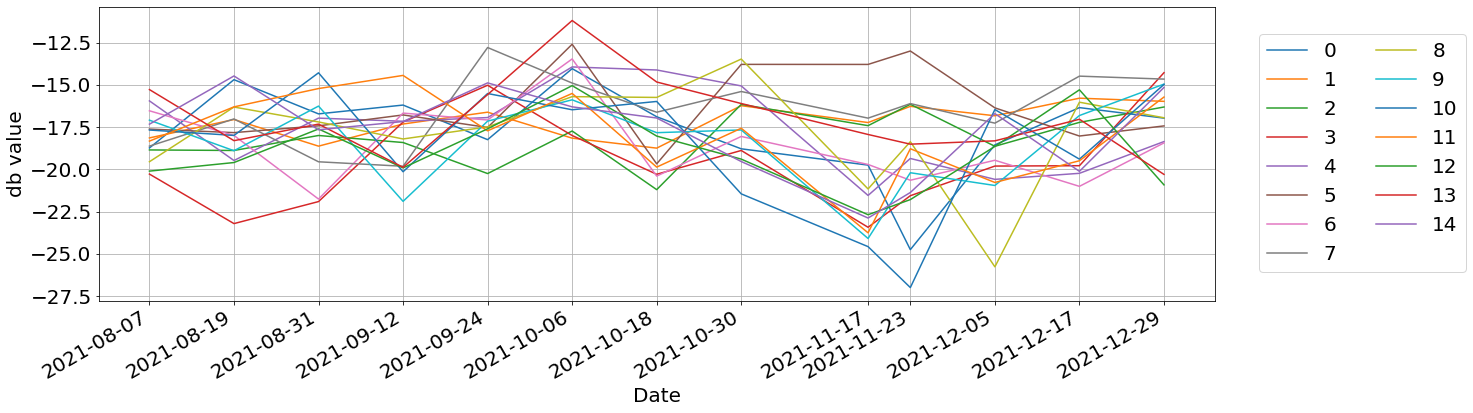

Map(center=[8.538675, 80.5428167], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [10]:
#@title Display the Result as a Plot
ncol = int(len(vals_df.columns)/font_size*1.5)+1
plt.clf()
vals_df.plot(grid=True, figsize=(width, height))
plt.xlabel('Date')
plt.ylabel('db value')
plt.xticks(list(dates))
plt.legend(loc=(1.04,0.1),ncol=ncol)
Save_the_plot = False  #@param {type:"boolean"}
Plot_name = 'Plot_6' #@param {type:"string"}
if Save_the_plot == True:
    plt.savefig(Plot_name+'.png')
plt.show()

#@markdown  ..

Show_on_map = True  #@param {type:"boolean"}
Include_raw_images = False  #@param {type:"boolean"}
Base_map = 'SATELLITE' #@param ['Default','HYBRID', 'SATELLITE', 'TERRAIN', 'ROADMAP']

if Show_on_map == True:
    center = [(lat_1+lat_2)/2,(lon_1+lon_2)/2]
    Map = geemap.Map(center = (center[0], center[1]), zoom=15)
    if Base_map != 'Default':
      Map.setOptions(Base_map)
    Map.addLayer(points_fc,{'color': 'RED'},'points')
    Map.add_labels(
    points_fc,
    'id',
    font_size="12pt",
    font_color="blue",
    # font_family="arial",
    font_weight="bold",
    )
    if Include_raw_images == False:
      display(Map)

if (Show_on_map == True and  Include_raw_images == True):
  for m in range(len(myset)) :
    Map.addLayer(globals()['img_%s' % myset[m]],{'min': -25, 'max' : 0}, str(dates[m].date()))
  display(Map)

Map(center=[8.538293, 80.532748], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

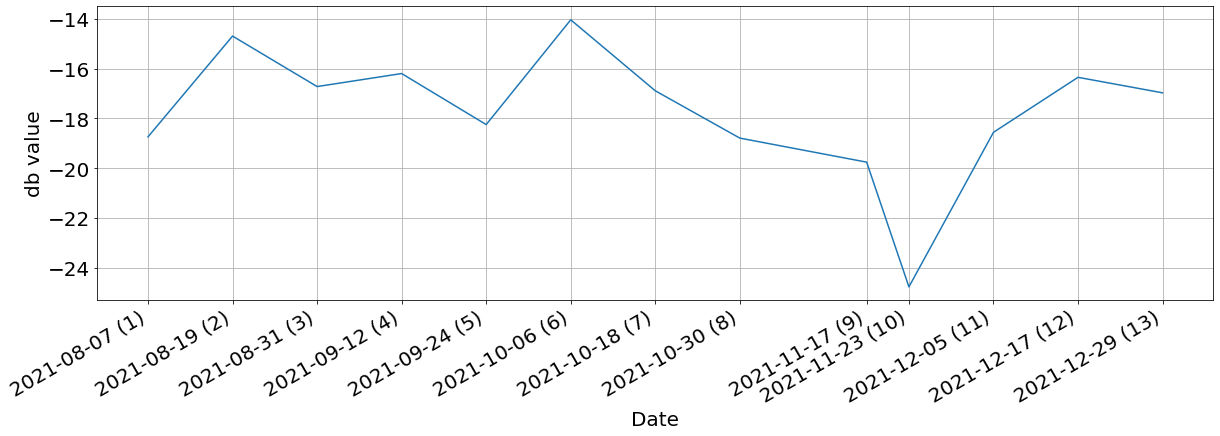


1 of 15


Map(center=[8.536865, 80.534233], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

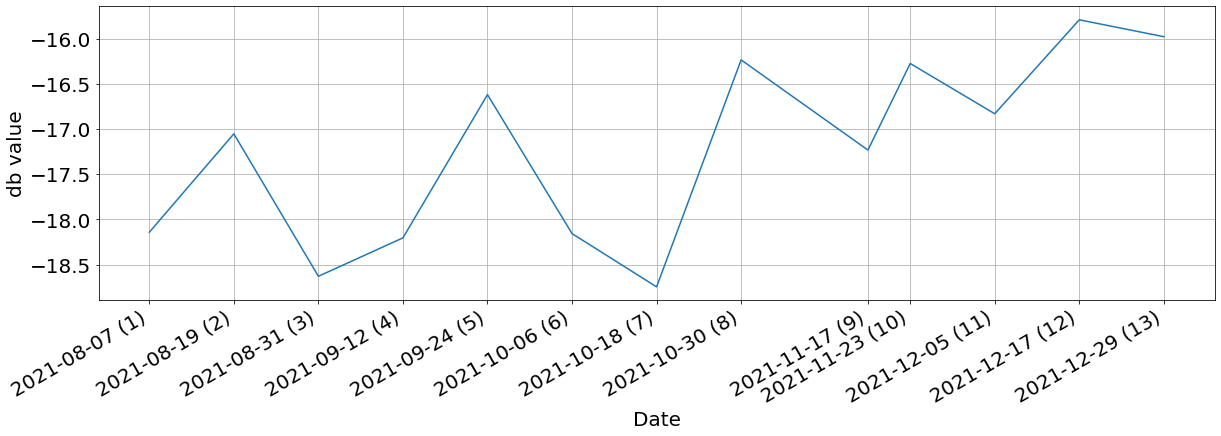


2 of 15


Map(center=[8.535451, 80.530563], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

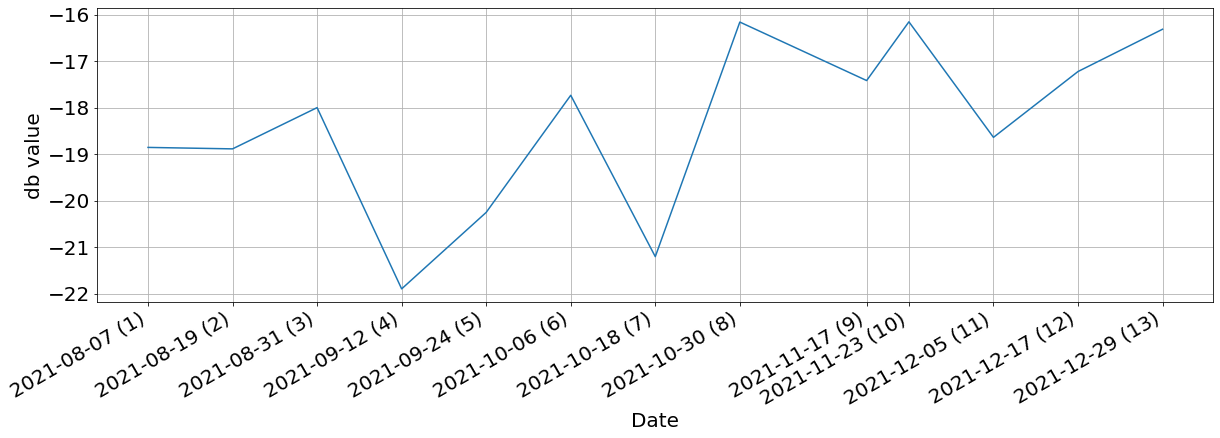


3 of 15


Map(center=[8.534343, 80.53341], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

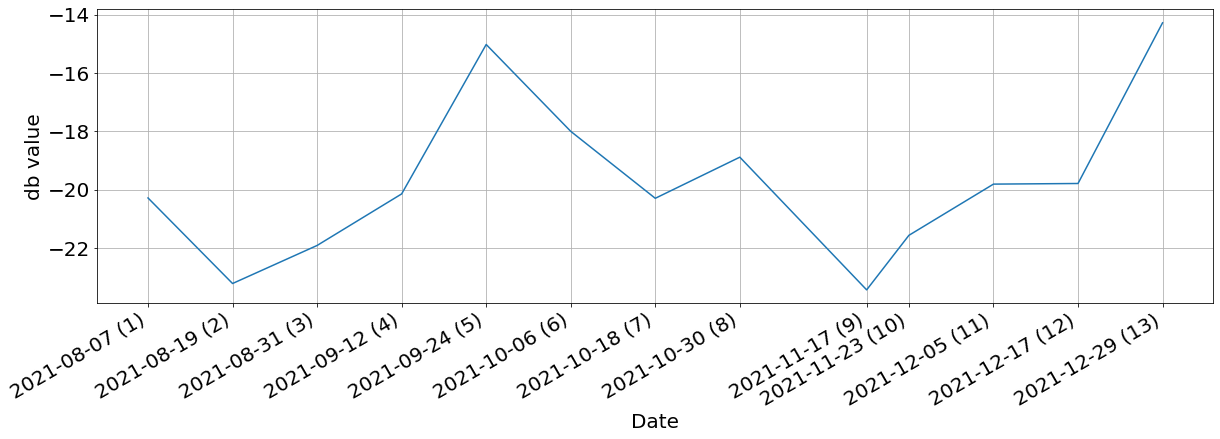


4 of 15


Map(center=[8.530707, 80.5381662], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

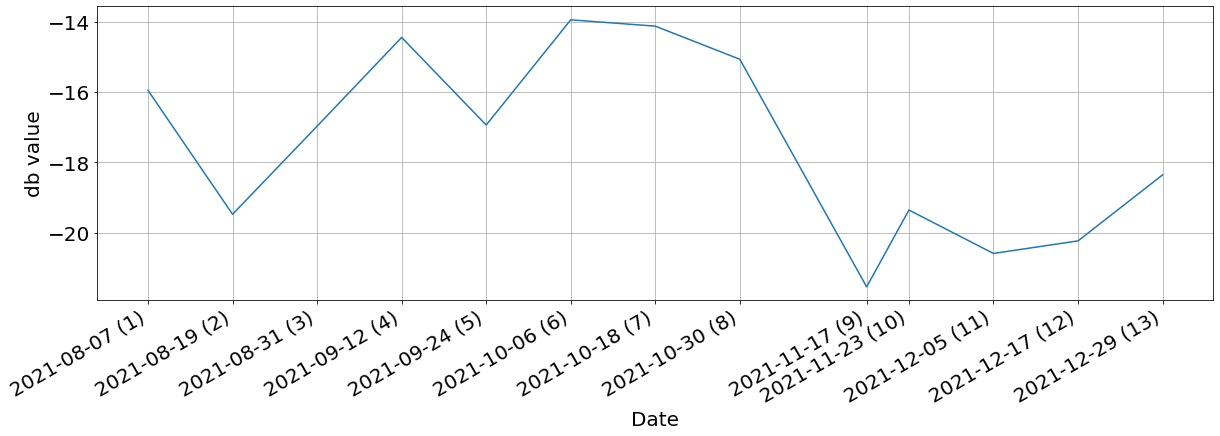


5 of 15


Map(center=[8.530033, 80.534907], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

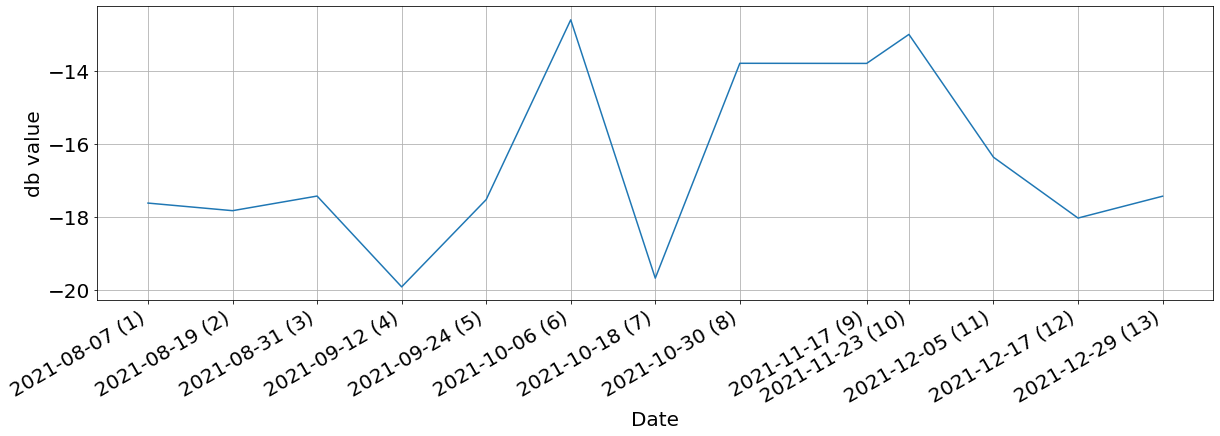


6 of 15


Map(center=[8.5370021, 80.5400283], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

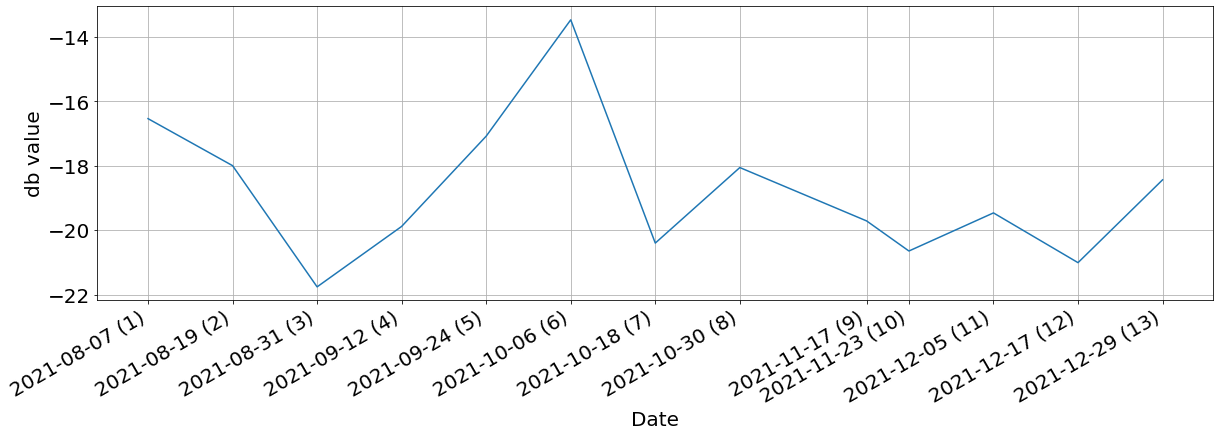


7 of 15


Map(center=[8.5375926, 80.5420321], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

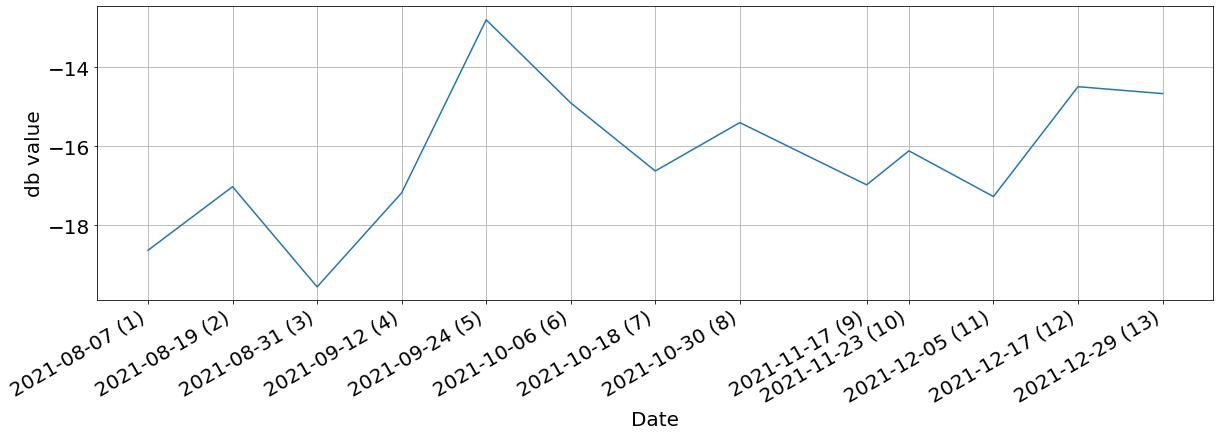


8 of 15


Map(center=[8.5370822, 80.5429531], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

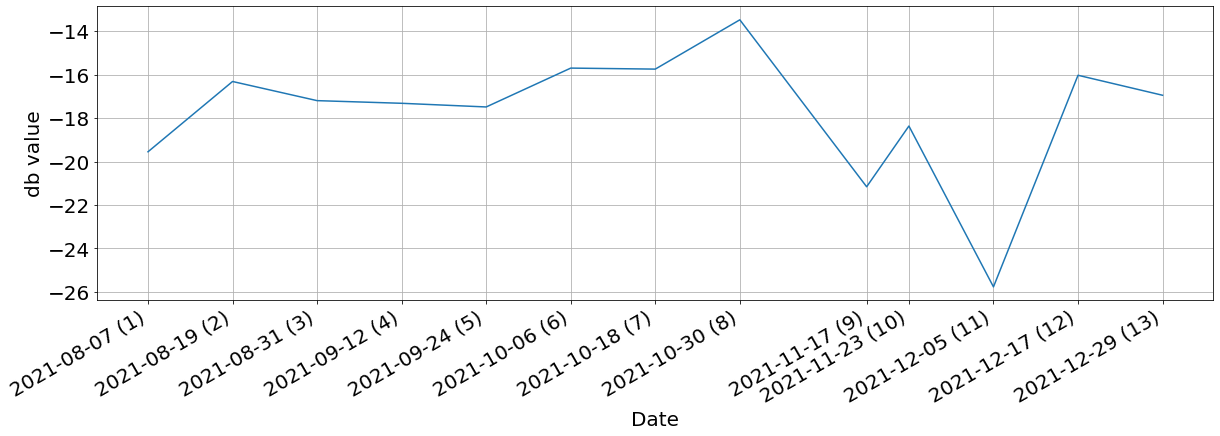


9 of 15


Map(center=[8.547317, 80.5508199], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

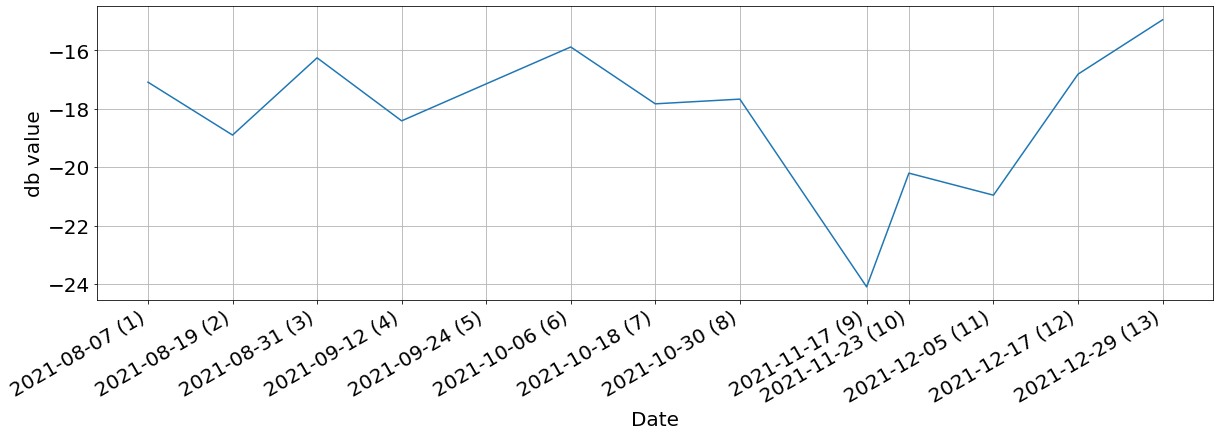


10 of 15


Map(center=[8.5472103, 80.5550704], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

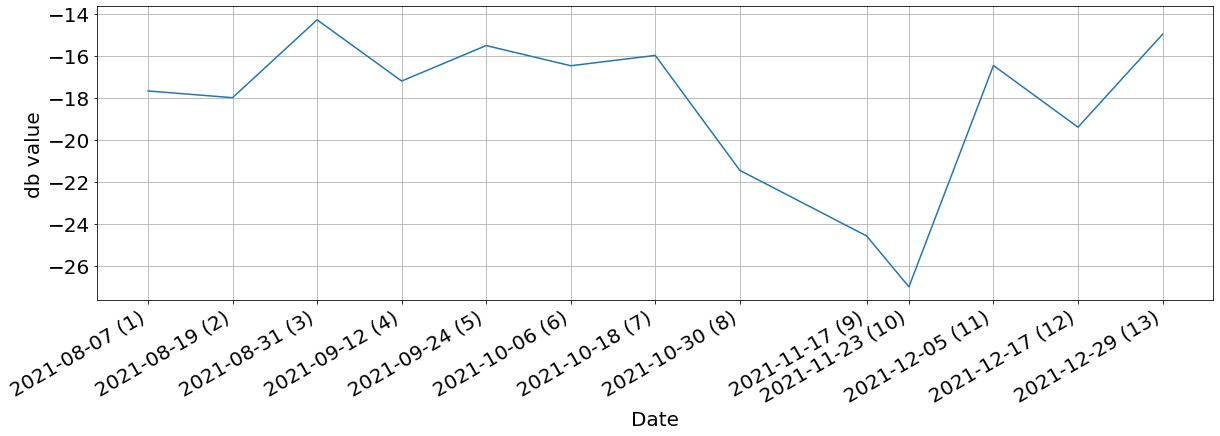


11 of 15


Map(center=[8.544128, 80.550557], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

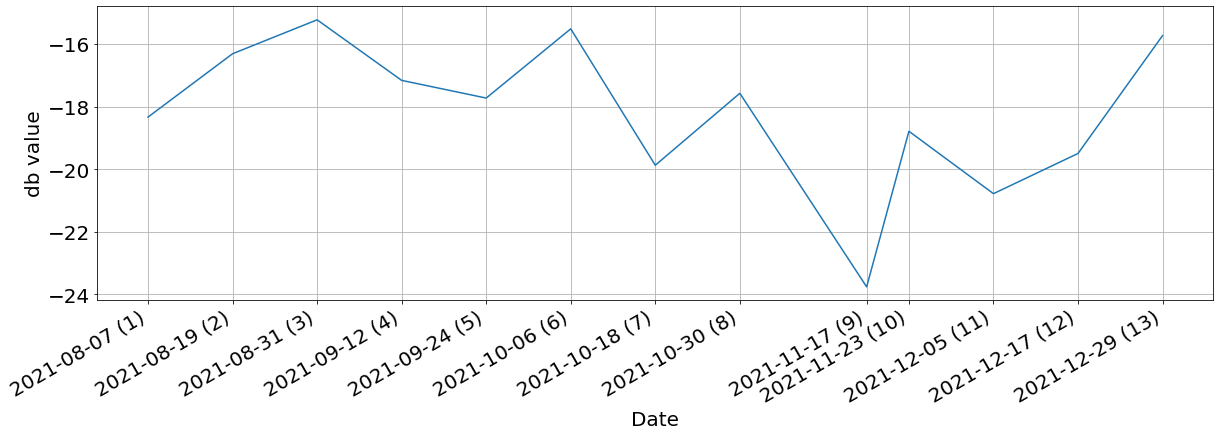


12 of 15


Map(center=[8.540925, 80.548168], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

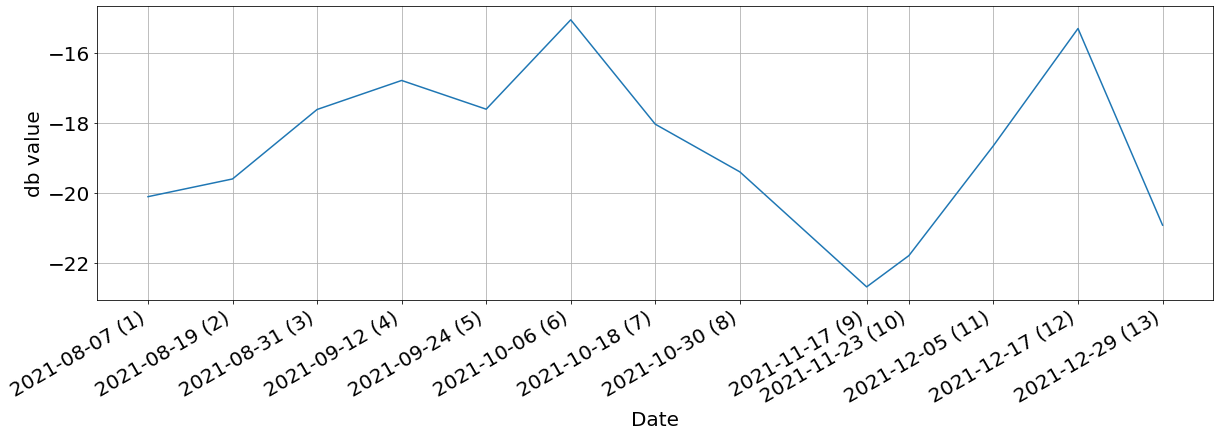


13 of 15


Map(center=[8.545769, 80.547467], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

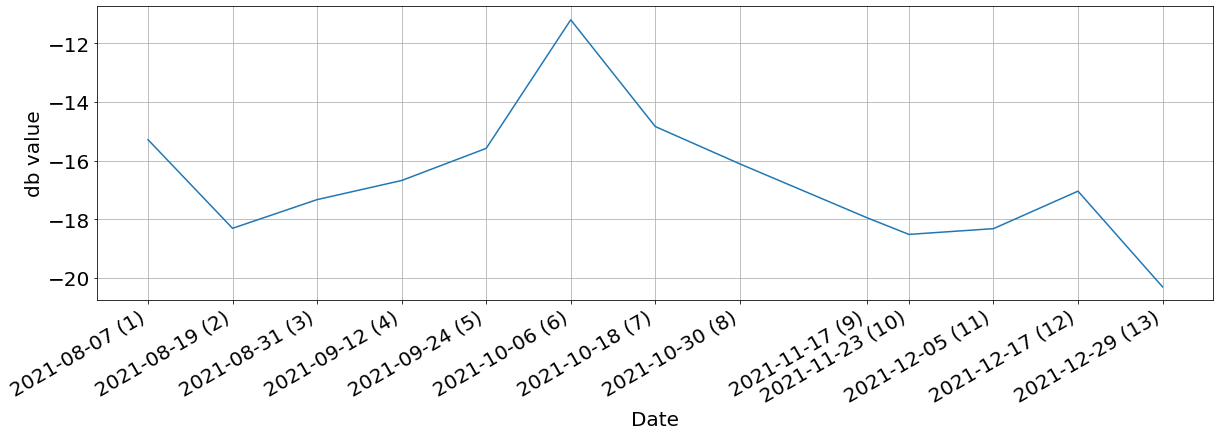


14 of 15


Map(center=[8.541399, 80.544181], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

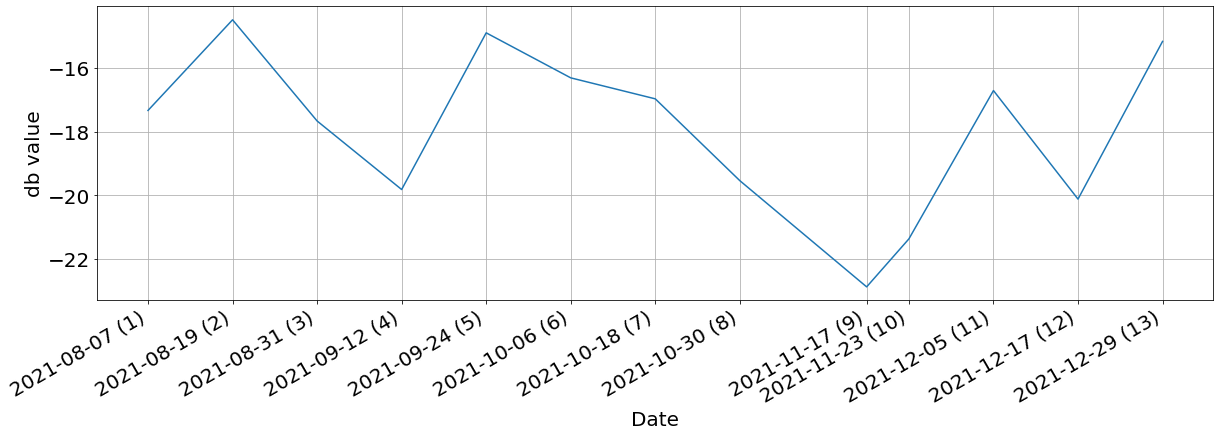


15 of 15


In [ ]:
#@title View Points seperately

plot = True #@param {type:"boolean"}
map = True #@param {type:"boolean"}

grnd_truth = []
c_count = 0

for i in range(len(points_list)):

    pnt = ee.Geometry.Point(points_list[i][0], points_list[i][1])

    if map == True:   
        Map = geemap.Map(center=(points_list[i][1], points_list[i][0]), zoom=20)
        Map.setOptions('HYBRID')
        Map.addLayer(pnt,{'color': 'RED'},'point')
        display(Map)

    if plot == True:
        plt.clf()
        vals_df[i].plot(grid=True, figsize=(width, height))
        plt.xlabel('Date')
        plt.ylabel('db value')
        plt.xticks(list(vals_df.index),lables)
          # plt.savefig('temporel.png')
        plt.show()
    
    time.sleep(1)
    print('\n'+str(i+1)+ ' of '+ str(len(points_list)))
    # num = input ("Press enter to move next")

In [ ]:
#@title Split the Data
if len(headers) >2:
  detail_column = headers[Detail.index]
  details_list = field_data_df[detail_column].unique()
  grouped = field_data_df.groupby(field_data_df.Detail)
  count = 0
  for detail in details_list:
      globals()['type_%s' % str(count)] = grouped.get_group(detail)
      # print(globals()['type_%s' % str(count)])
      count = count + 1


  i = 0
  for detail in details_list:
          print(i)
          points_list_df = globals()['type_%s' % str(i)].filter(['Lon','Lat'])
          points_list = points_list_df.values.tolist()
          points = ee.Geometry.MultiPoint(points_list)

          point_features = []
          for j in range (len(points_list)):
            point_features.append(ee.Feature(ee.Geometry.Point(points_list[j]), {'id': j}))

          points_fc = ee.FeatureCollection(point_features)

          vals_list = []
          bands = [band]
          val_list = []
          count = 0

          Show_Results_split = False  #@param {type:"boolean"}
          
                  
          if Show_Results_split == True:
                display(vals_df)


          Show_the_plots = True  #@param {type:"boolean"}
          if Show_the_plots == True:

              ncol = int(len(vals_df.columns)/font_size*1.5)+1
              plt.clf()
              vals_df.plot(grid=True, figsize=(width, height))
              plt.xlabel(details_list[i])
              plt.ylabel('db value')
              plt.xticks(list(dates))
              plt.legend(loc=(1.04,0.1),ncol=ncol)
              # plt.savefig('temporel2.png')
              plt.show()

          Show_on_map = False  #@param {type:"boolean"}
          Include_raw_images = False  #@param {type:"boolean"}
          Base_map = 'Default' #@param ['Default','HYBRID', 'SATELLITE', 'TERRAIN', 'ROADMAP']


          Show_on_map_split = Show_on_map
          if Show_on_map_split == True:
            Map = geemap.Map(center=(points_list[0][1], points_list[0][0]), zoom=12)
            if Base_map != 'Default':
                Map.setOptions(Base_map)
            Map.addLayer(points_fc,{},'points')
            Map.add_labels(
            points_fc,
            'id',
            font_size="12pt",
            font_color="blue",
            font_family="arial",
            font_weight="bold",
            )
            if Include_raw_images == False:
                  display(Map)

            if (Show_on_map == True and  Include_raw_images == True):
              for m in range(len(myset)) :
                Map.addLayer(globals()['img_%s' % myset[m]],{'min': -25, 'max' : 0}, str(dates[m].date()))
              display(Map)

          i=i+1
else:
  print('splitting is not applicable')

splitting is not applicable
